In [2]:
import datetime
"""
This module contains functions for calculating financial metrics.

Functions:
- calculate_returns: Calculate the returns of a given stock.
- calculate_volatility: Calculate the volatility of a given stock.
- plot_stock_prices: Plot the stock prices of a given stock.
"""
from datetime import date
from datetime import timedelta, timezone
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt

In [3]:
# Set the display format for floating point numbers in pandas
pd.options.display.float_format = "{:,.6f}".format

start = datetime.date.today()-datetime.timedelta(365*10)
end = datetime.date.today()

# start = datetime.date(2011, 11, 25)
# end = datetime.date(2021, 11, 23)

prices = yfin.download(["^GSPC", "^RUT"], start, end)["Adj Close"]
prices = prices.rename(columns={"^GSPC": "SP500", "^RUT": "Russell2000"})
# Calcalue the log returns of the S&P 500 and Russell 2000

log_returns = np.log(prices / prices.shift(1))
print(log_returns.head())

[*********************100%***********************]  2 of 2 completed

Ticker                        SP500  Russell2000
Date                                            
2014-09-15 00:00:00+00:00       NaN          NaN
2014-09-16 00:00:00+00:00  0.007457     0.003874
2014-09-17 00:00:00+00:00  0.001295     0.002534
2014-09-18 00:00:00+00:00  0.004879     0.004652
2014-09-19 00:00:00+00:00 -0.000477    -0.010710


In [4]:
# Calcualte Future Value of each index using continuous compounding 
i = log_returns.mean()
print(i)
futrue_value = np.exp(i * 252 * 10) * 1000
print(futrue_value)

# Calcualte Future Value of each index using standard/discrete compounding 
futrue_value_disc = (1 + i) ** (252 * 10) * 1000
print(futrue_value_disc)

Ticker
SP500         0.000404
Russell2000   0.000241
dtype: float64
Ticker
SP500         2,766.326337
Russell2000   1,833.217118
dtype: float64
Ticker
SP500         2,765.758273
Russell2000   1,833.083536
dtype: float64


In [5]:
prices.index = prices.index.tz_localize(None)  # Remove timezone awareness from the DatetimeIndex
currYear = prices.loc[
    datetime.date.today() - datetime.timedelta(365) : datetime.date.today()  # noqa E203 to ignore PEP8 warning about space before slice
]

# Calculate the maximum and minimum prices over the last 365 days
# currYear.max() gives the highest price within this period
# currYear.min() gives the lowest price within this period
# The difference between these two values represents the price fluctuation (range)
price_range = currYear.max() - currYear.min()

# Output the price range (maximum - minimum) for the selected period
print(price_range)


Ticker
SP500         1,549.830078
Russell2000     626.729980
dtype: float64


In [6]:
(currYear.max() - currYear.min()) / prices.iloc[-1]

Ticker
SP500         0.283278
Russell2000   0.298759
dtype: float64

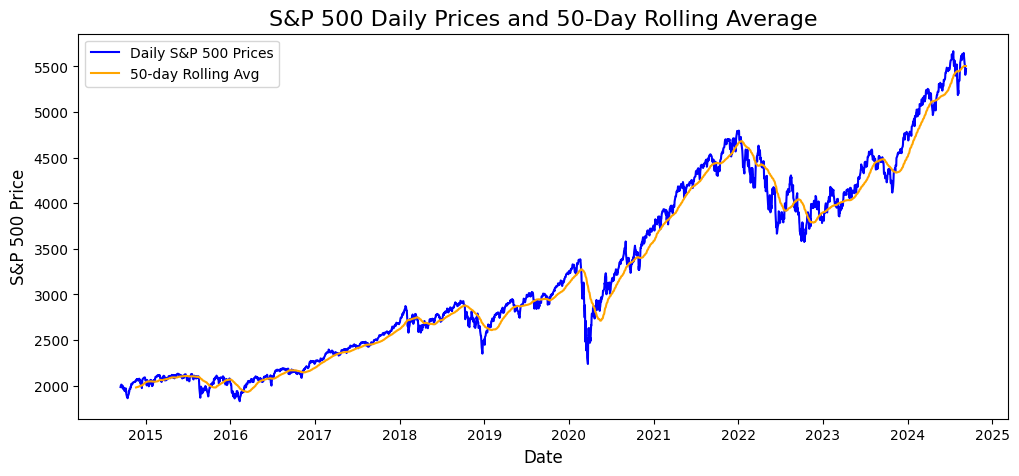

In [7]:
# Compute the 50-day rolling average
prices["SP500 50 day_rolling_avg"] = prices["SP500"].rolling(50).mean()

# Set figure size
plt.figure(figsize=(12, 5))

# Plot the daily S&P 500 prices
plt.plot(prices.index, prices["SP500"], label="Daily S&P 500 Prices", color='blue')

# Plot the 50-day rolling average
plt.plot(prices.index, prices["SP500 50 day_rolling_avg"], label="50-day Rolling Avg", color='orange')

# Add title and labels
plt.title("S&P 500 Daily Prices and 50-Day Rolling Average", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("S&P 500 Price", fontsize=12)

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Volatility

## Comparing each day's price to the moving average

In [8]:
# Calculate the 50-day rolling average of the S&P 500 prices
rolling_50 = prices.rolling(50).mean()
# Calculate the absolute difference between the S&P 500 prices and the 50-day rolling average
abs_diff = abs(prices - rolling_50)
# Calculate the volatility as the mean of the absolute difference divided by the prices
volatility = (abs_diff/prices).mean()
print(volatility)

Ticker
SP500                      0.029772
Russell2000                0.038856
SP500 50 day_rolling_avg   0.022173
dtype: float64


## Standard Deviation

In [9]:
# Calculate standard deviation (By Price)
prices.std()

Ticker
SP500                      1,009.516875
Russell2000                  353.221316
SP500 50 day_rolling_avg     981.078952
dtype: float64

In [10]:
# Calculate standard deviation (By returns)
log_returns.std()  # Standard deviation of log returns

Ticker
SP500         0.011297
Russell2000   0.014479
dtype: float64

In [33]:
# Write a function that takes an end date and a list of tickers. 
# Return the high minus low price for each ticker, moving average volitility, std and daily return percentage for the last 365 days 
# before the end date
# Return a data frame that has columns for each ticker and rows for each metric 
# HighMinusLow	MovingAverageVolatility	StandardDeviation	Daily Return Percentage

def calculate_returns(ticker, start,end):
    # Download the stock price data
    prices = yfin.download(ticker, start, end)["Adj Close"]
    
    # Calculate the high minus low price for each ticker
    high_minus_low = (prices.max() - prices.min())/prices.iloc[-1]

    high_minus_low = pd.DataFrame(high_minus_low, columns=["HighMinusLow"])

    # Calculate the daily log returns
    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]

    # Calculate the moving average volatility
    moving_avg_volatility = ((abs(prices - prices.rolling(50).mean()))/prices).mean()
    moving_avg_volatility = pd.DataFrame(moving_avg_volatility, columns=["MovingAverageVolatility"])    
    
    # Calculate the daily return percentage
    daily_return_percentage = (prices.pct_change() * 100).mean()
    daily_return_percentage = pd.DataFrame(daily_return_percentage, columns=["DailyReturnPercentage"])
    
    # Calculate the standard deviation
    std = returns.std()
    std = pd.DataFrame(std, columns=["StandardDeviation"])

    # Combine the metrics into a single DataFrame
    metrics = pd.concat([high_minus_low, moving_avg_volatility, std, daily_return_percentage], axis=1)
    
    return metrics

In [34]:
calculate_returns(
    ["^GSPC", "^RUT"],
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    
)

[*********************100%***********************]  2 of 2 completed


,HighMinusLow,MovingAverageVolatility,StandardDeviation,DailyReturnPercentage
Ticker,,,,
^GSPC,0.626900,0.036391,0.013807,0.053512
^RUT,0.691960,0.048667,0.018029,0.035684
